# makemore: part 5

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappins to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random 
random.seed(42)
random.shuffle(words)

In [214]:
# build the dataset

block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])   # 10%

torch.Size([182484, 8]) torch.Size([182484])
torch.Size([22869, 8]) torch.Size([22869])
torch.Size([22793, 8]) torch.Size([22793])


In [215]:
for x,y in zip(Xtr[:20],Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> j
.......j --> a
......ja --> y
.....jay --> r
....jayr --> i
...jayri --> e
..jayrie --> l
.jayriel --> .
........ --> j
.......j --> a
......ja --> x
.....jax --> l
....jaxl --> y
...jaxly --> n
..jaxlyn --> n
.jaxlynn --> .
........ --> o
.......o --> a
......oa --> k
.....oak --> l


In [216]:
# Copy pasted from lecture4

# -----------------------------------------------------------------------------------
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if x.ndim == 2:
            dim = 0
        elif x.ndim == 3:
            dim = (0,1)
        if self.training:
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------
class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
# -----------------------------------------------------------------------------------
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters for all layers and strech them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [217]:
torch.manual_seed(42);

In [218]:
n_embd = 48 # dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer: make less confident
            
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

83371


In [206]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  1, 14, 14],
        [ 5, 20,  8,  1, 14,  9,  5, 12],
        [ 0,  0,  0,  1, 14, 14,  1, 12],
        [ 0,  0,  0, 26, 21,  8,  1,  9]])

In [207]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 30)
FlattenConsecutive : (4, 4, 60)
Linear : (4, 4, 100)
BatchNorm1d : (4, 4, 100)
Tanh : (4, 4, 100)
FlattenConsecutive : (4, 2, 200)
Linear : (4, 2, 100)
BatchNorm1d : (4, 2, 100)
Tanh : (4, 2, 100)
FlattenConsecutive : (4, 200)
Linear : (4, 100)
BatchNorm1d : (4, 100)
Tanh : (4, 100)
Linear : (4, 27)


In [208]:
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim=True) # 1, 1, 68
print(emean.shape)
evar = e.var((0,1), keepdim=True) # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
ehat.shape

torch.Size([1, 1, 68])


torch.Size([32, 4, 68])

In [219]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb, = Xtr[ix], Ytr[ix] # # batch X, Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3088
  10000/ 200000: 2.3432
  20000/ 200000: 2.0128
  30000/ 200000: 2.1816
  40000/ 200000: 2.4165
  50000/ 200000: 2.2166
  60000/ 200000: 1.5353
  70000/ 200000: 2.1488
  80000/ 200000: 1.9960
  90000/ 200000: 1.8119
 100000/ 200000: 2.1973
 110000/ 200000: 1.5662
 120000/ 200000: 1.3955
 130000/ 200000: 1.1703
 140000/ 200000: 2.1496
 150000/ 200000: 1.7552
 160000/ 200000: 1.8570
 170000/ 200000: 1.5590
 180000/ 200000: 1.9277
 190000/ 200000: 2.1257


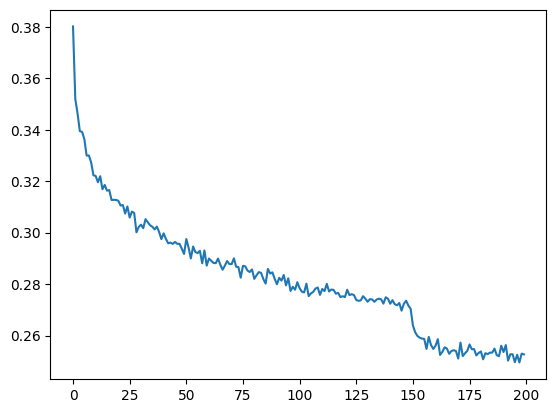

In [220]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

In [221]:
for layer in model.layers:
    layer.training = False

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.7649389505386353
val 1.9827508926391602


## performance log

- original (3 char context, 200 hidden neurons, 12K params): train 2.05, val 2.105
- context: 3 --> 8 (22K params): train 1.92, val 2.02
- flat --> hierarhical, fixed batchnorm: 1.901 val 2.018
- scaled up model 8 char context, 24 emb, 128 hidden neurons, (77k params): train 1.768 val 1.988
- 16 char context, 24 emb, 48 hidden, 18k params: train 1.84 val 2.07
- 8 char context, 48 emb, 128 hidden, 83k params: train 1.765 val 1.982

In [223]:
#sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        #forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break if we get .
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

bronce.
hanad.
jackin.
audoriah.
danbel.
muelo.
yarold.
reve.
zoella.
xiyenne.
kamal.
rophe.
amarri.
abdulmariarose.
azael.
russeda.
birky.
ally.
wagor.
mykia.
